In [1]:
from __future__ import print_function, division
from collections import defaultdict, OrderedDict
import gzip
import pickle
import json

import uproot
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np

from fnal_column_analysis_tools import hist
from fnal_column_analysis_tools.hist import plot

In [2]:
with gzip.open("hists.pkl.gz") as fin:
    hists = pickle.load(fin)

In [3]:
process = hist.Cat("process", "Process", sorting='placement')
process_cats = ("dataset", "AK8Puppijet0_isHadronicV")
process_map = OrderedDict()
#process_map["QCD"] = ("QCD*", slice(None))
#process_map["QCDinV"] = ("Z*", 0)
process_map["Hcc"] = ("GluGluHToCC", 2)
process_map["Hbb"] = ("GluGluHToBB", 3)
process_map["Zqq"] = ("ZJetsToQQ_HT*", 1)
process_map["Zcc"] = ("ZJetsToQQ_HT*", 2)
process_map["Zbb"] = ("ZJetsToQQ_HT*", 3)
process_map["Wqq"] = ("WJetsToQQ_HT*", 1)
process_map["Wcs"] = ("WJetsToQQ_HT*", 2)
process_map["Top"] = ("TTTo*", slice(None))
process_map["QCD"] = ("QCD*", slice(None))


for key in hists.keys():
    hists[key] = hists[key].group(process, process_cats, process_map)

/Users/ncsmith/src/fnal-column-analysis-tools/binder/fnal_column_analysis_tools/hist/hist_tools.py:478: RuntimeWarning: Allocating a large (>10M bin) histogram!
  warnings.warn("Allocating a large (>10M bin) histogram!", RuntimeWarning)


<IPython.core.display.Javascript object>


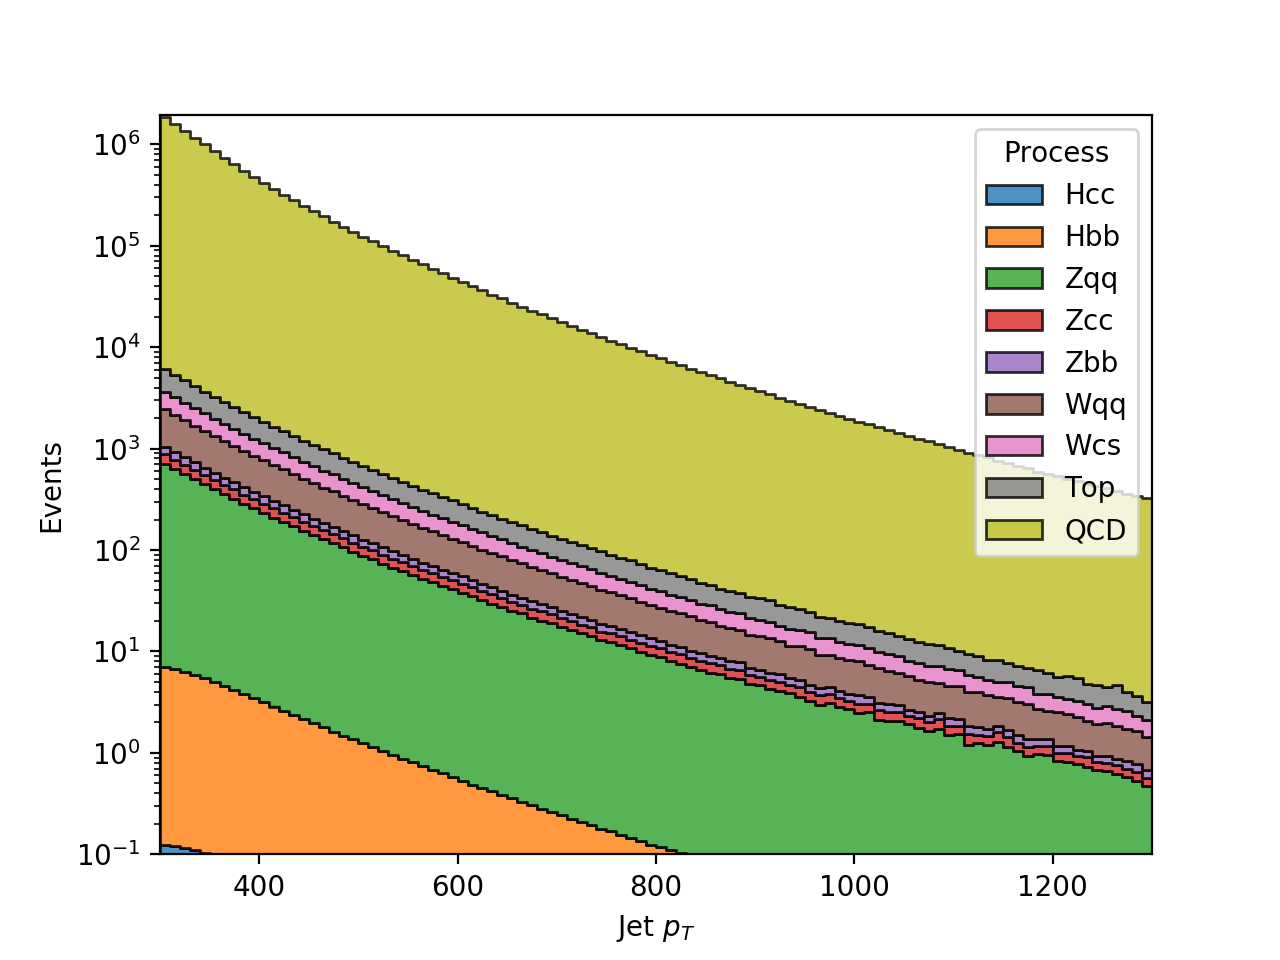

(0.1, 1932886.4625)

In [4]:
fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 0.8}
fig, ax, _ = plot.plot1d(hists['hjetpt'], overlay="process", stack=True, fill_opts=fill_opts)
ax.set_yscale('log')
ax.set_ylim(.1,None)

In [5]:
nbins = sum(sum(arr.size for arr in h._sumw.values()) for h in hists.values())
nfilled = sum(sum(np.sum(arr>0) for arr in h._sumw.values()) for h in hists.values())
print("Now %.1fM bins" % (nbins/1e6, ))
print("Nonzero bins: %.1f%%" % (100*nfilled/nbins, ))

Now 38.4M bins
Nonzero bins: 5.0%


In [6]:
with gzip.open("tagtensor.pkl.gz", "wb") as fout:
    pickle.dump(hists['htagtensor'], fout, protocol=2)  # for python2 compatibility

In [7]:
# check if unmatched jet in V sample is any different than QCD
# answer was no
if False:
    hqcd_comp = hists['hsculpt_b'].sum("AK8Puppijet0_msd")["QCD*"]
    fig,axes = plot.plotgrid(hqcd_comp, col="AK8Puppijet0_pt", overlay="process", error_opts={}, density=True)
    axes[0][0].set_ylim(1e-3,None)
    axes[0][0].set_yscale('log')

In [8]:
x = hists['htagtensor'].sum("AK8Puppijet0_pt", "AK8Puppijet0_msd").sum("AK8Puppijet0_N2sdb1_ddt", overflow='under')
pvals = x[:,:,0.6:,0.:].sum("AK8Puppijet0_deepdoubleb", "AK8Puppijet0_deepdoublec", "AK8Puppijet0_deepdoublecvb").values()
avals = x.sum("AK8Puppijet0_deepdoubleb", "AK8Puppijet0_deepdoublec", "AK8Puppijet0_deepdoublecvb").values()
evals = {k:pvals[k]/avals[k] for k in pvals.keys()}
evals

{('Hcc',): 0.78774077,
 ('Hbb',): 0.5965121,
 ('Zqq',): 0.34490004,
 ('Zcc',): 0.7318041,
 ('Zbb',): 0.545513,
 ('Wqq',): 0.3534154,
 ('Wcs',): 0.5843001,
 ('Top',): 0.36576164,
 ('QCD',): 0.19429715}

<IPython.core.display.Javascript object>


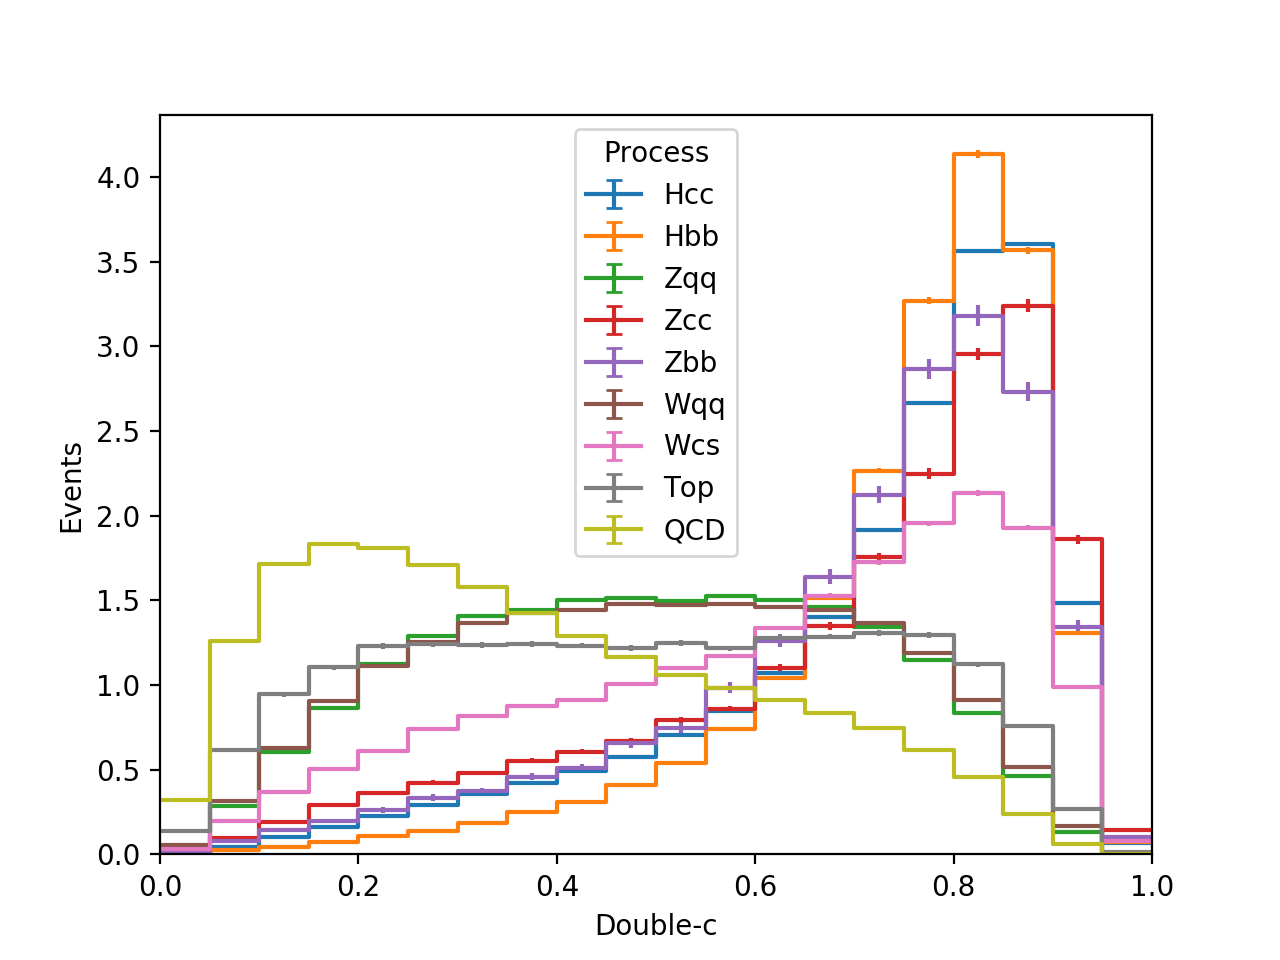

In [9]:
fig, ax, _ = plot.plot1d(x.sum("AK8Puppijet0_deepdoubleb").project("AK8Puppijet0_deepdoublecvb", slice(0.15,None)),
            overlay="process", error_opts={}, density=True
           )

msd bin: [40, 100)


<IPython.core.display.Javascript object>


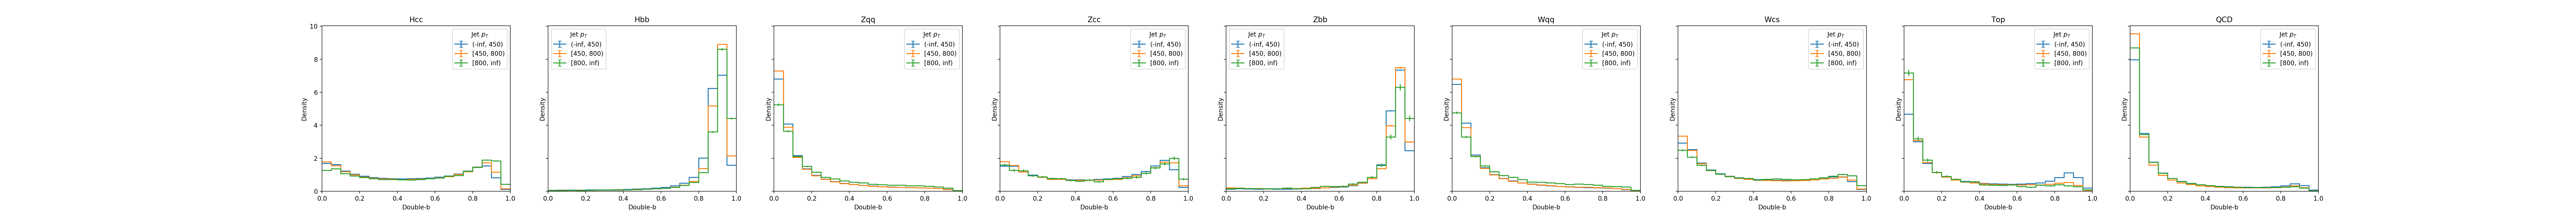

<IPython.core.display.Javascript object>


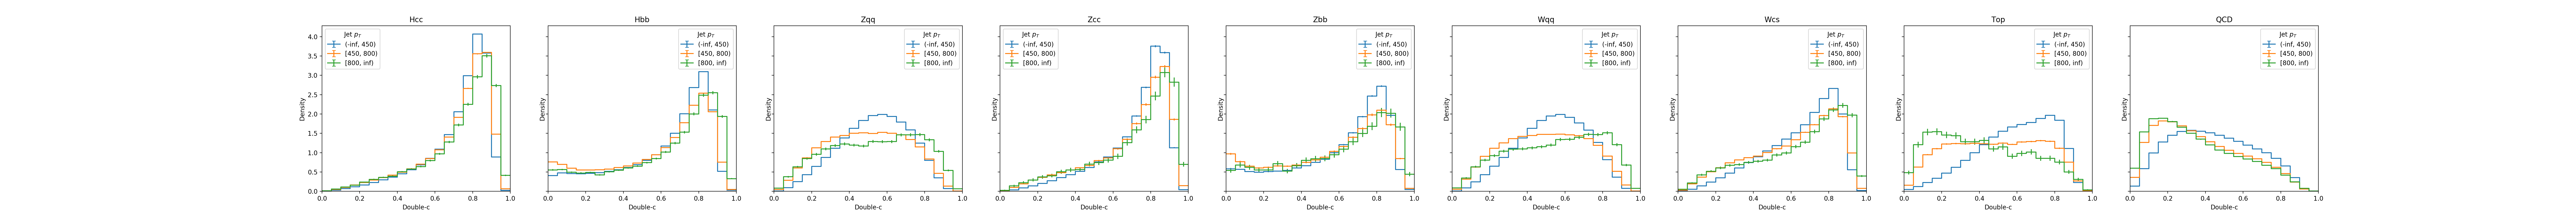

<IPython.core.display.Javascript object>


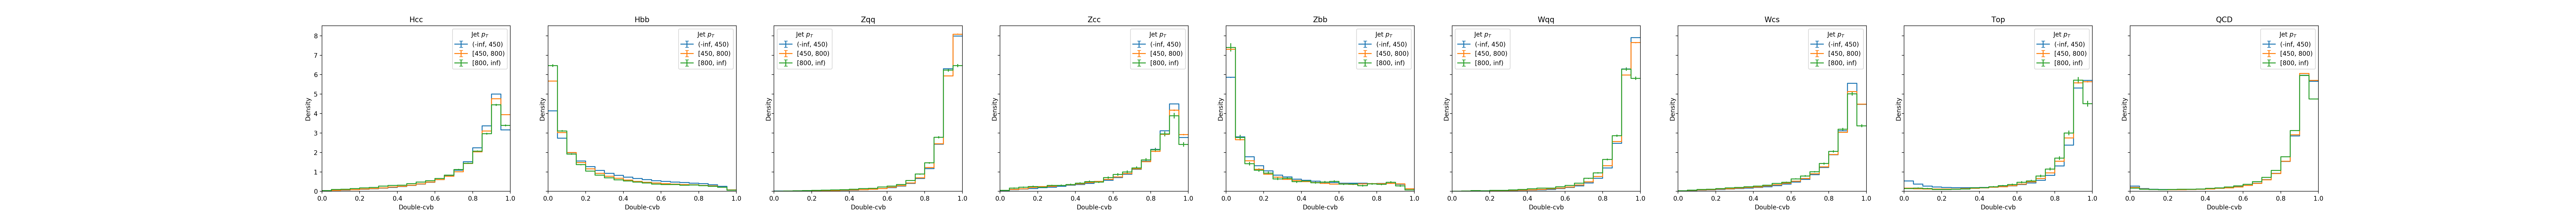

In [10]:
plot_opts = {'error_opts': {}, 'overflow': 'none', 'overlay_overflow': 'all', 'density': True}

print("msd bin:", hists['htagtensor'].axis("AK8Puppijet0_msd")[1])
htagtensor = hists['htagtensor'].project("AK8Puppijet0_msd", overflow='none').project("AK8Puppijet0_N2sdb1_ddt", overflow='under')
htagtensor.label = "Density"

hb = htagtensor.sum("AK8Puppijet0_deepdoublec", "AK8Puppijet0_deepdoublecvb")
fig1,_ = plot.plotgrid(hb, col="process", overlay="AK8Puppijet0_pt", **plot_opts)
fig1.savefig("plots/doubleb.pdf")

hc = htagtensor.sum("AK8Puppijet0_deepdoubleb", "AK8Puppijet0_deepdoublecvb")
fig2,_ = plot.plotgrid(hc, col="process", overlay="AK8Puppijet0_pt", **plot_opts)
fig2.savefig("plots/doublec.pdf")

hcvb = htagtensor.sum("AK8Puppijet0_deepdoubleb", "AK8Puppijet0_deepdoublec")
fig3,_ = plot.plotgrid(hcvb, col="process", overlay="AK8Puppijet0_pt", **plot_opts)
fig3.savefig("plots/doublecvb.pdf")

In [11]:
def roc(values, bkg, sig):
    bkgeff_cut = np.cumsum(values[(bkg,)][::-1])
    bkgeff_cut = bkgeff_cut[::-1] / bkgeff_cut[-1]
    sigeff_cut = np.cumsum(values[(sig,)][::-1])
    sigeff_cut = sigeff_cut[::-1] / sigeff_cut[-1]
    return bkgeff_cut, sigeff_cut

<IPython.core.display.Javascript object>


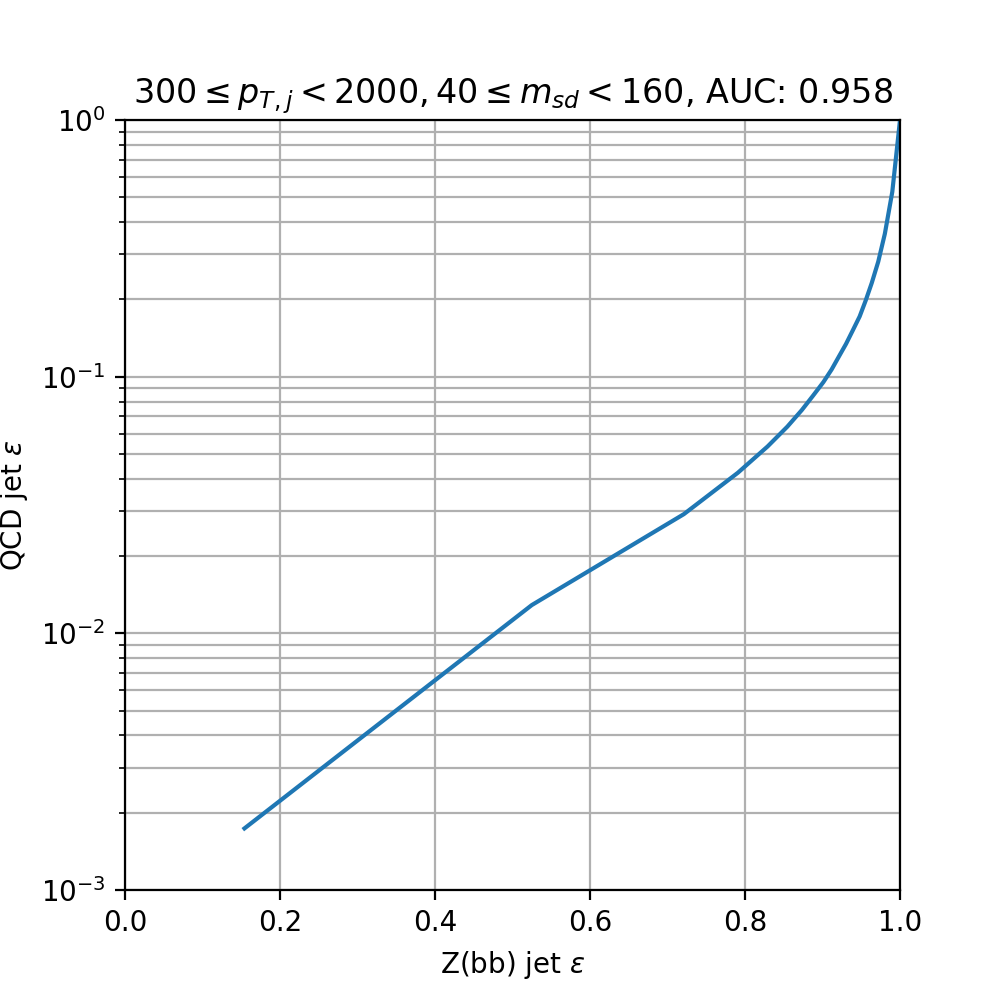

In [12]:
rocvals = htagtensor.project("AK8Puppijet0_pt", slice(450,None), overflow='over') \
                    .sum("AK8Puppijet0_deepdoublec", "AK8Puppijet0_deepdoublecvb") \
                    .values()
qcdeff_b, zbbeff_b = roc(rocvals, 'QCD', 'Zbb')

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(zbbeff_b, qcdeff_b)
ax.set_xlabel("Z(bb) jet $\epsilon$")
ax.set_xlim(0,1)
ax.set_ylabel("QCD jet $\epsilon$")
ax.set_yscale('log')
ax.set_ylim(1e-3, 1)
ax.grid(which='both')
auc = 1+np.trapz(y=qcdeff_b, x=zbbeff_b)  # range of integration is 1 to 0
ax.set_title("$300 \leq p_{T,j} < 2000, 40 \leq m_{sd} < 160$, AUC: %.3f" % auc)
fig.savefig("plots/Zbb_roc.pdf")

<IPython.core.display.Javascript object>


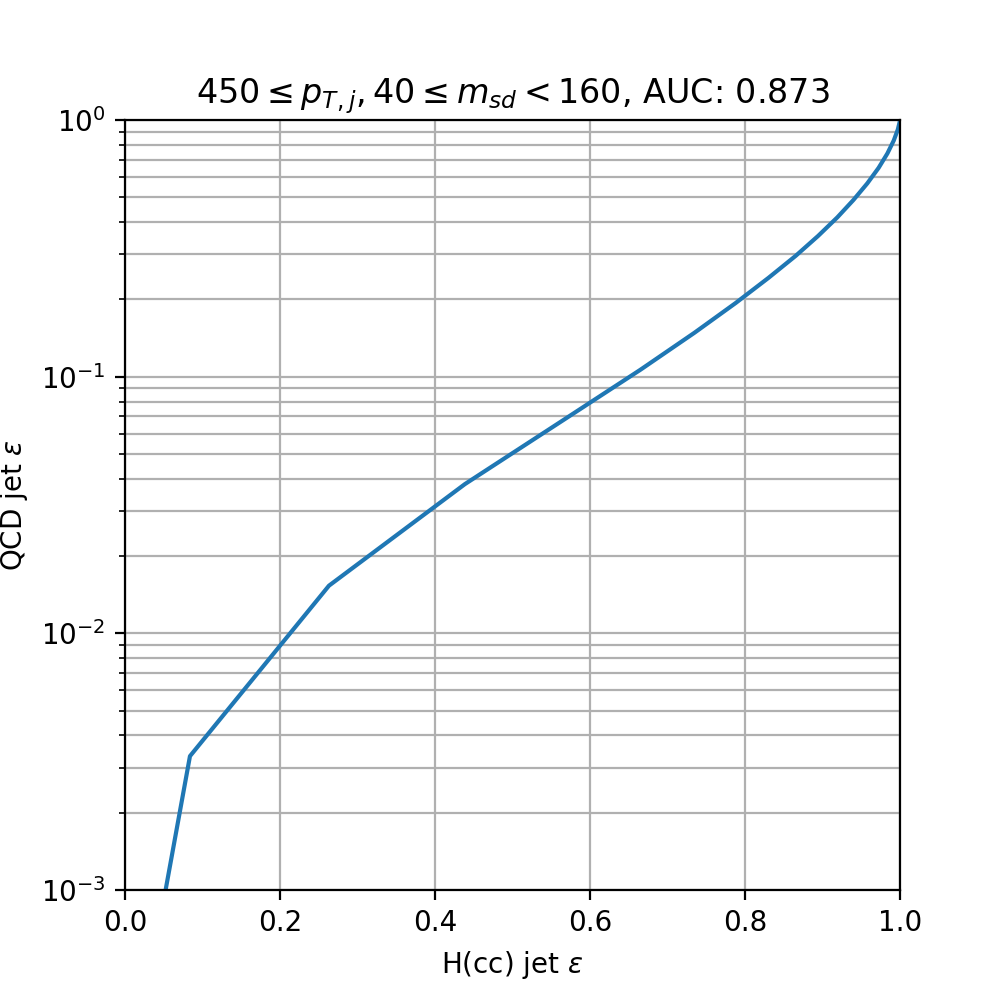

In [13]:
rocvals = htagtensor.project("AK8Puppijet0_pt", slice(450,None), overflow='over') \
                    .sum("AK8Puppijet0_deepdoubleb", "AK8Puppijet0_deepdoublecvb") \
                    .values()
qcdeff_c, zcceff_c = roc(rocvals, 'QCD', 'Hcc')

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(zcceff_c, qcdeff_c)
ax.set_xlabel("H(cc) jet $\epsilon$")
ax.set_xlim(0,1)
ax.set_ylabel("QCD jet $\epsilon$")
ax.set_yscale('log')
ax.set_ylim(1e-3, 1)
ax.grid(which='both')
auc = 1+np.trapz(y=qcdeff_c, x=zcceff_c)
ax.set_title("$450 \leq p_{T,j}, 40 \leq m_{sd} < 160$, AUC: %.3f" % auc)
fig.savefig("plots/Hcc_roc.pdf")

<IPython.core.display.Javascript object>


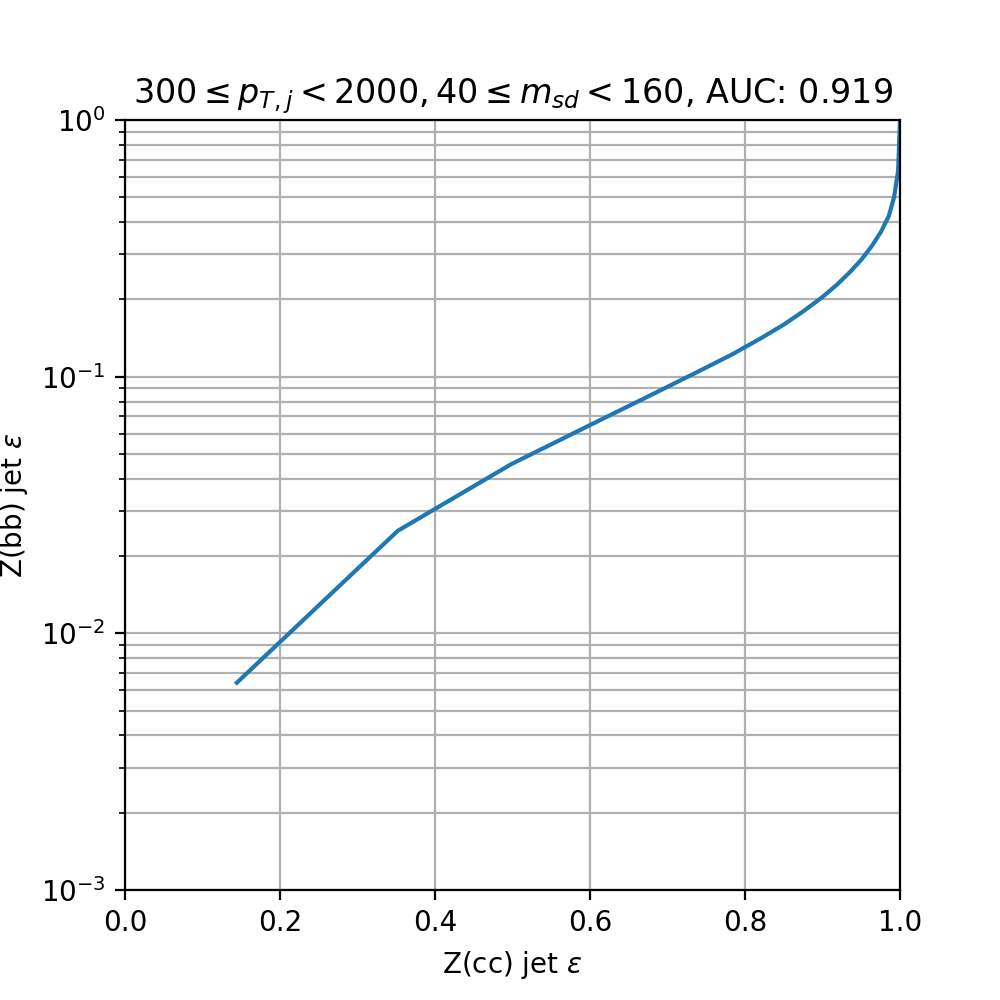

In [14]:
rocvals = htagtensor.project("AK8Puppijet0_pt", slice(450,None), overflow='over') \
                    .sum("AK8Puppijet0_deepdoubleb", "AK8Puppijet0_deepdoublec") \
                    .values()
zbbeff_cvb, zcceff_cvb = roc(rocvals, 'Zbb', 'Zcc')

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(zcceff_cvb, zbbeff_cvb)
ax.set_xlabel("Z(cc) jet $\epsilon$")
ax.set_xlim(0,1)
ax.set_ylabel("Z(bb) jet $\epsilon$")
ax.set_yscale('log')
ax.set_ylim(1e-3, 1)
ax.grid(which='both')
auc = 1+np.trapz(y=zbbeff_cvb, x=zcceff_cvb)
ax.set_title("$300 \leq p_{T,j} < 2000, 40 \leq m_{sd} < 160$, AUC: %.3f" % auc)
fig.savefig("plots/Zcvb_roc.pdf")

In [15]:
def rebin_quantile(ax, vals, quantiles, cmpLess=False):
    quantiles.sort()
    idir = 1 if cmpLess else -1
    cdf = vals[::idir].cumsum()
    cdf /= cdf[-1]
    bins = np.searchsorted(cdf, quantiles)
    if bins[0] > 0:
        bins = np.insert(bins, 0, 0)
    if bins[-1] < len(ax.edges()):
        bins = np.append(bins, -1)
    edges = ax.edges()[bins]
    qbin = hist.Bin(ax.name, ax.label, edges)
    return qbin


[-0.25  -0.125 -0.05  -0.025  0.025  0.25 ]


<IPython.core.display.Javascript object>


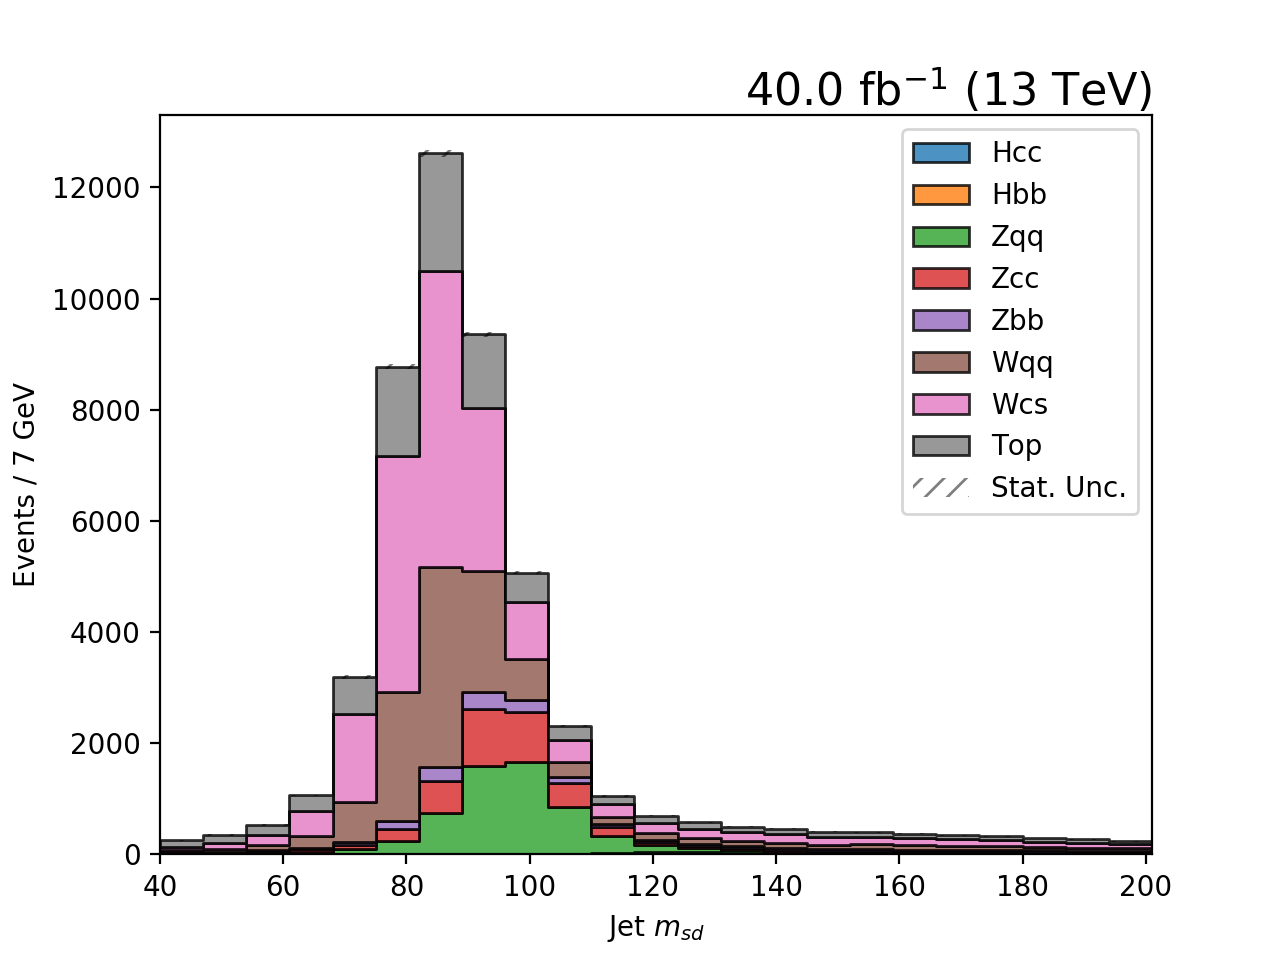

In [16]:
n2name = "AK8Puppijet0_N2sdb1_ddt"
rocn2 = hists['hsculpt'].project("AK8Puppijet0_pt", slice(450., None)) \
            .project("AK8Puppijet0_msd")
n2 = rocn2.axis(n2name)

n2proj = rocn2.sum("AK8Puppijet0_deepdoubleb", "AK8Puppijet0_deepdoublec", "AK8Puppijet0_deepdoublecvb", overflow='all')

quantiles = np.array([0.01, 0.1, 0.2, 0.5])
n2_coarse = rebin_quantile(n2, n2proj.values()[('QCD',)], quantiles, True)
print(n2_coarse.edges())

if False:
    figq, axq = plt.subplots(1,1, figsize=(5,5))
    plot.plot1d(axq, n2proj['QCD'], n2, error_opts={}, density=True)
    for i,e in enumerate(n2_coarse.edges()[1:-1]):
        axq.axvline(e, linestyle='--', color='k')
        axq.text(e, axq.get_ylim()[1], "QCD $\epsilon=%.2f$" % quantiles[i], rotation=90, va='top', ha='right')
    axq.legend()
    axq.set_xlim(-.25,.25)
    axq.set_ylim(0,None)
    axq.set_title("$450 \leq p_{T,j}, 40 \leq m_{sd} < 160$")
    #figq.savefig("plots/n2_qcdquantiles.pdf")

sculpt = hists['hsculpt'] \
              .project(n2, slice(None, 0.), overflow='under') \
              .project("AK8Puppijet0_pt", slice(450., None)) \
              .project("AK8Puppijet0_deepdoubleb", slice(None, 0.985), overflow='under') \
              .project("AK8Puppijet0_deepdoublec", slice(0.69, None), overflow='over') \
              .project("AK8Puppijet0_deepdoublecvb", slice(None), overflow='over')

lumi = 40.
sculpt.scale(lumi)
sculpt.label = "Events / 7 GeV"
import re
noqcd = re.compile("(?!QCD).*")
fillerr = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
fig, ax, _ = plot.plot1d(sculpt[noqcd,:], overlay="process", stack=True, fill_opts=fill_opts, error_opts=fillerr)
ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, None)
ax.legend()
lumi = plt.text(1., 1., r"%.1f fb$^{-1}$ (13 TeV)" % lumi, fontsize=16, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)


if False:
    rocvals = rocn2.rebin(n2, n2_coarse).values()
    for k in rocvals.keys(): rocvals[k] = rocvals[k].cumsum(axis=-1)

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    for i in range(n2_coarse.size-3):
        n2bin = n2_coarse[i+1]
        qcdeff_b, zbbeff_b = roc({k:v[:,i] for k,v in rocvals.items()}, 'QCD', 'Zbb')
        ax.plot(zbbeff_b, qcdeff_b, label="%.12g" % n2bin.hi)

    ax.set_xlabel("Z(bb) jet $\epsilon$")
    ax.set_xlim(0,1)
    ax.set_ylabel("QCD jet $\epsilon$")
    ax.set_yscale('log')
    ax.set_ylim(1e-3, 1)
    #ax.set_ylim(0,1)
    ax.legend(title="N2DDT cut")
    ax.grid(which='both')
    ax.set_title("$450 \leq p_{T,j}, 40 \leq m_{sd} < 160$")

    fig.savefig("plots/doubleb_roc_n2.pdf")

In [17]:
hwps = hists['hsculpt'] \
  .project(n2, slice(None, 0.), overflow='under') \
  .project("AK8Puppijet0_pt", slice(450., None)) \
  .project("AK8Puppijet0_msd", slice(75, 110)) #slice(103, 145))

In [18]:
vals = hwps.values(overflow='all')
axes = hwps.axes()[1:]
sig = 40.*sum([v for k,v in vals.items() if 'Hbb' in k[0]])
bkg = 40.*sum([v for k,v in vals.items() if 'Hbb' not in k[0]])

In [19]:
v = []
for icvl, cvl in enumerate(axes[1].identifiers(overflow='all')):
    for icvb, cvb in enumerate(axes[2].identifiers(overflow='all')):
        ssum = sig[:,icvl:,icvb:].sum()
        bsum = bkg[:,icvl:,icvb:].sum()
        v.append((ssum/(np.sqrt(bsum)+1), cvl.lo, cvb.lo))

In [20]:
v = [x for x in v if x[1]!=0.84 and x[2]!=0.12]

In [21]:
v.sort(key=lambda x: x[0], reverse=True)
for i in v[:10]:
    print("CvL >= {1} CvB >= {2:.2f} S/(sqrtB+1) = {0:.4f}".format(*i))

CvL >= 0.69 CvB >= -inf S/(sqrtB+1) = 0.0568
CvL >= 0.58 CvB >= -inf S/(sqrtB+1) = 0.0543
CvL >= 0.79 CvB >= -inf S/(sqrtB+1) = 0.0541
CvL >= 0.83 CvB >= -inf S/(sqrtB+1) = 0.0491
CvL >= -inf CvB >= -inf S/(sqrtB+1) = 0.0411
CvL >= 0.87 CvB >= -inf S/(sqrtB+1) = 0.0393
CvL >= 0.79 CvB >= 0.17 S/(sqrtB+1) = 0.0373
CvL >= 0.69 CvB >= 0.17 S/(sqrtB+1) = 0.0363
CvL >= 0.83 CvB >= 0.17 S/(sqrtB+1) = 0.0348
CvL >= 0.58 CvB >= 0.17 S/(sqrtB+1) = 0.0321


In [22]:
hwps = hists['hsculpt'] \
  .project(n2, slice(None, 0.), overflow='under') \
  .project("AK8Puppijet0_pt", slice(450., None)) \
  .project("AK8Puppijet0_msd", slice(103, 145))

vals = hwps.values(overflow='all')
axes = hwps.axes()[1:]
sig = 40.*sum([v for k,v in vals.items() if 'Hbb' in k[0]])
bkg = 40.*sum([v for k,v in vals.items() if 'Hbb' not in k[0]])

v = []
for ibvl, bvl in enumerate(axes[0].identifiers(overflow='all')):
    ssum = sig[ibvl:,:,:].sum()
    bsum = bkg[ibvl:,:,:].sum()
    v.append((ssum/(np.sqrt(bsum)+1), bvl.lo))

v.sort(key=lambda x: x[0], reverse=True)
for i in v[:10]:
    print("BvL >= {1} S/(sqrtB+1) = {0:.4f}".format(*i))

BvL >= 0.89 S/(sqrtB+1) = 1.3507
BvL >= 0.85 S/(sqrtB+1) = 1.2899
BvL >= 0.92 S/(sqrtB+1) = 1.2051
BvL >= 0.93 S/(sqrtB+1) = 1.0910
BvL >= 0.7 S/(sqrtB+1) = 1.0079
BvL >= -inf S/(sqrtB+1) = 0.2703
BvL >= 0.985 S/(sqrtB+1) = 0.1030


<IPython.core.display.Javascript object>


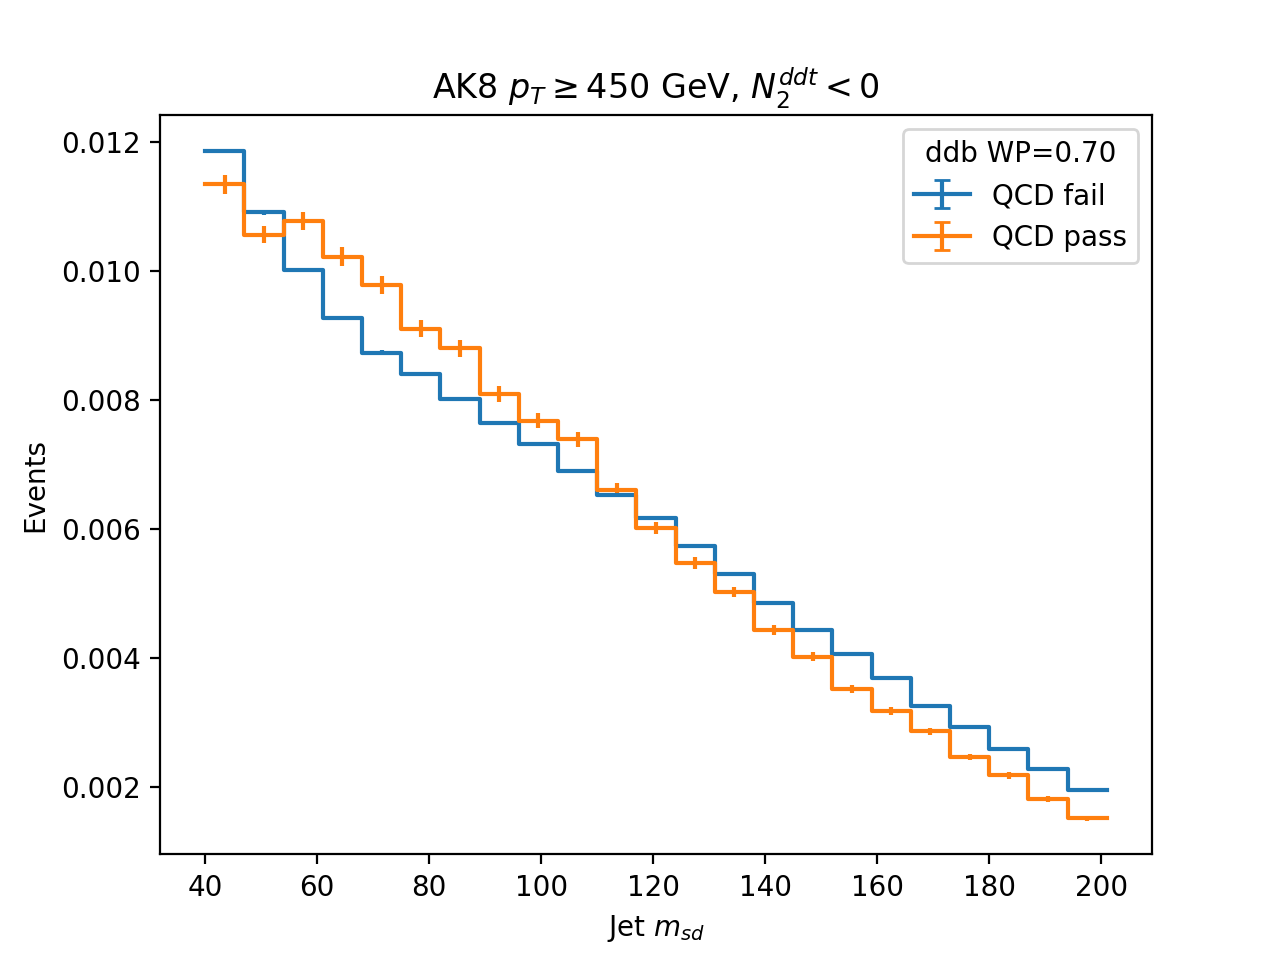

<IPython.core.display.Javascript object>


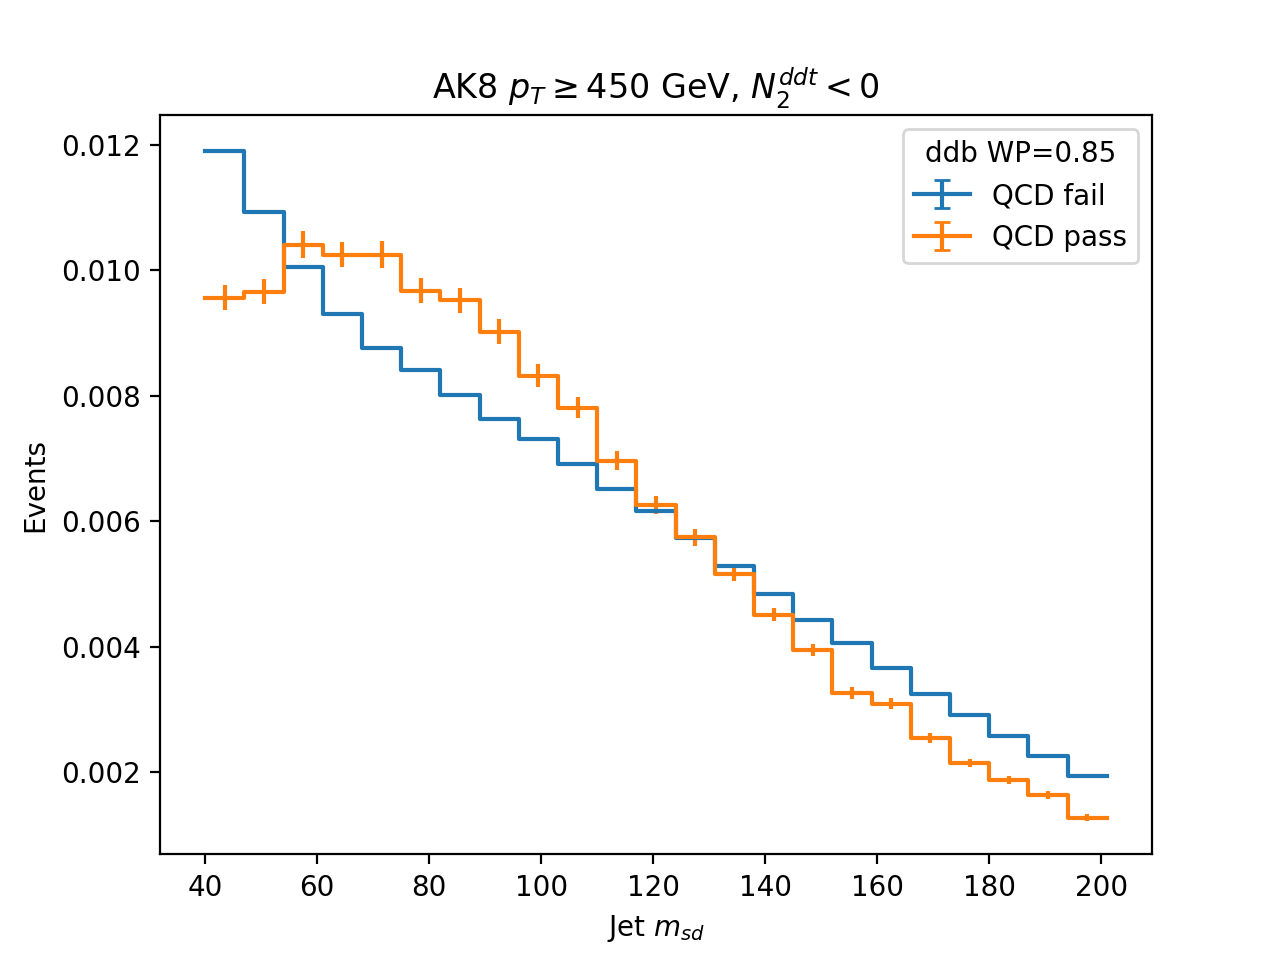

<IPython.core.display.Javascript object>


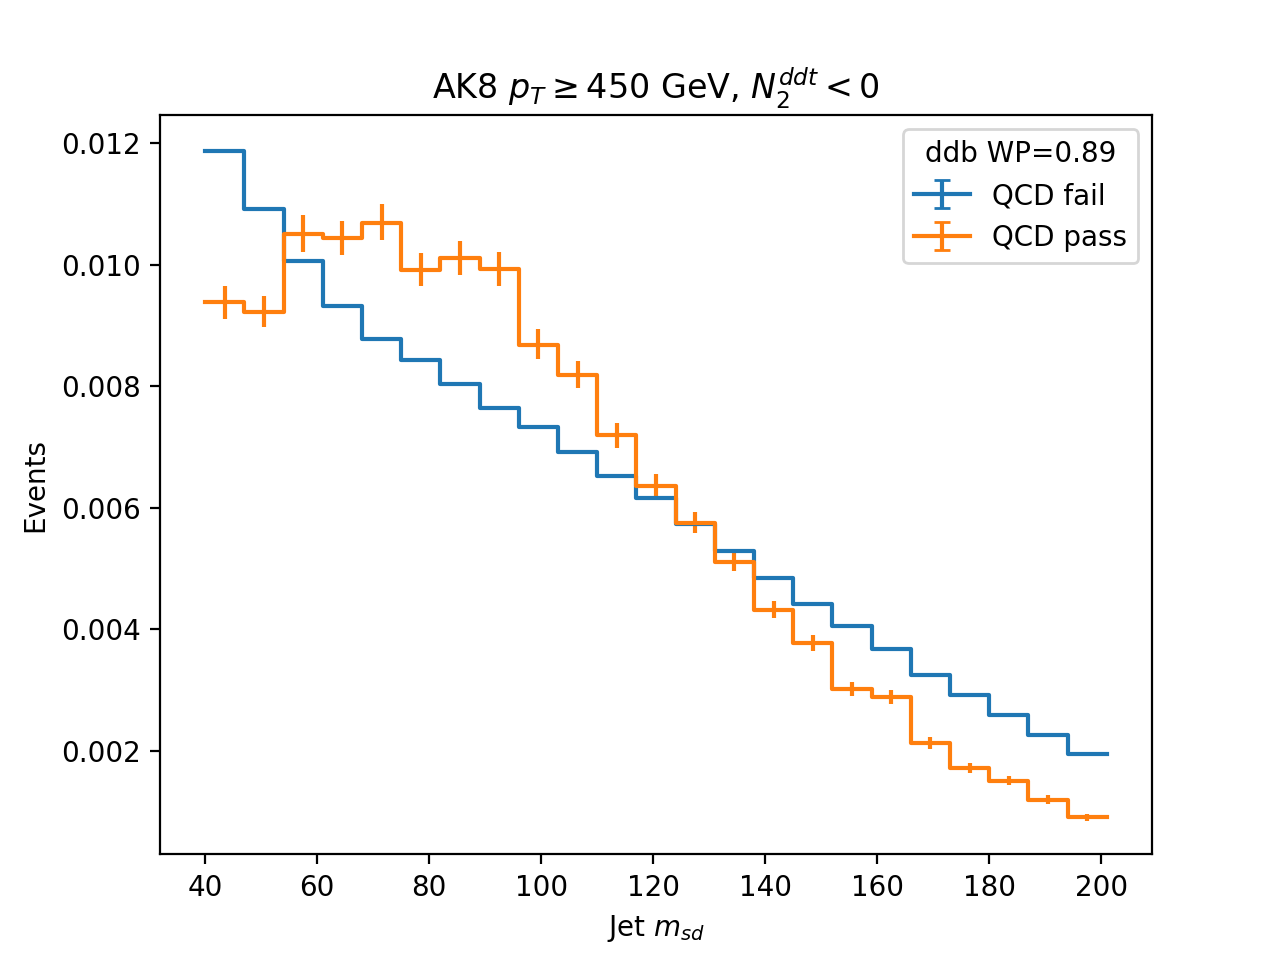

<IPython.core.display.Javascript object>


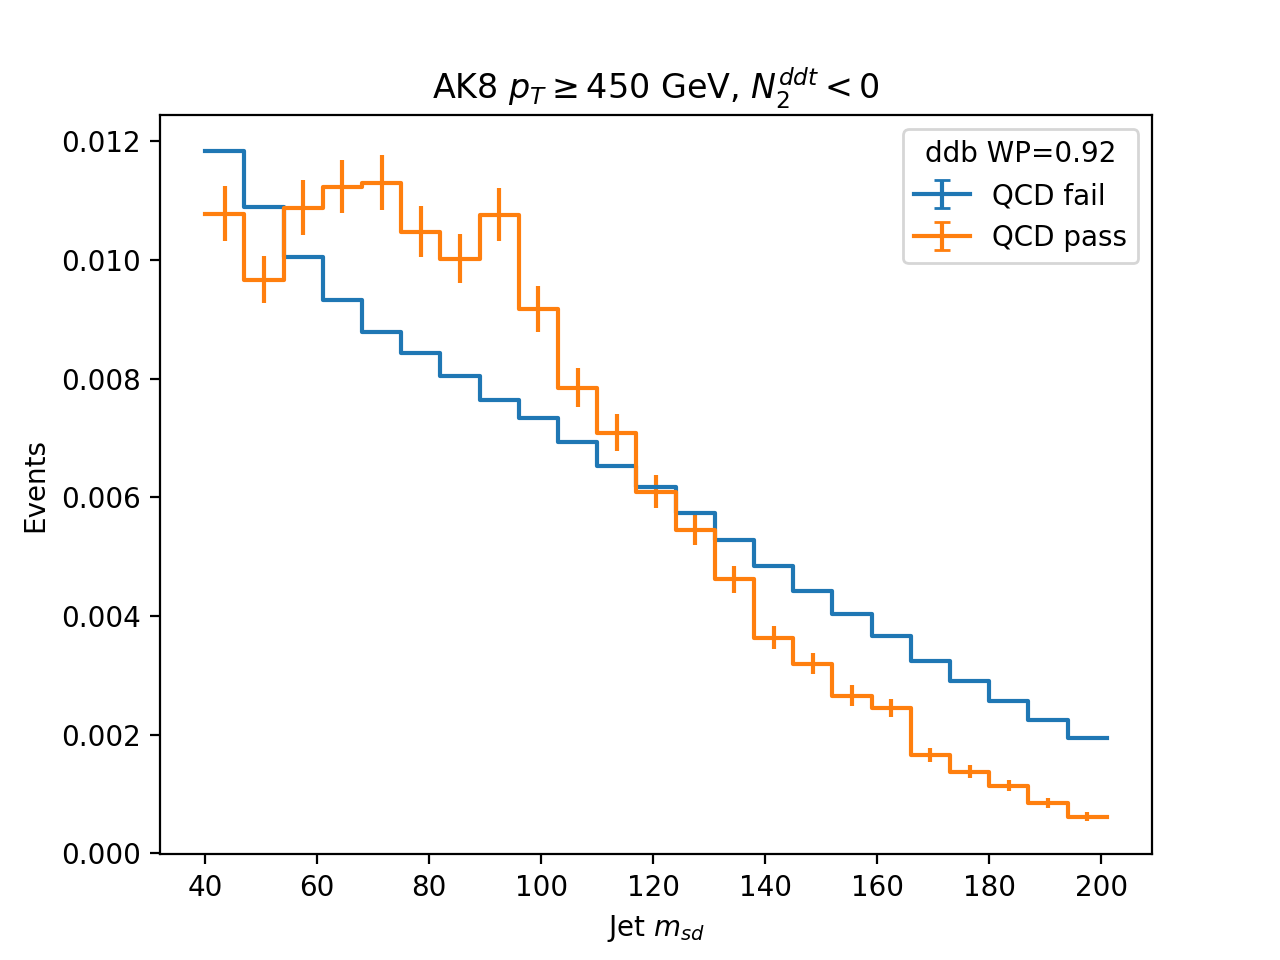

<IPython.core.display.Javascript object>


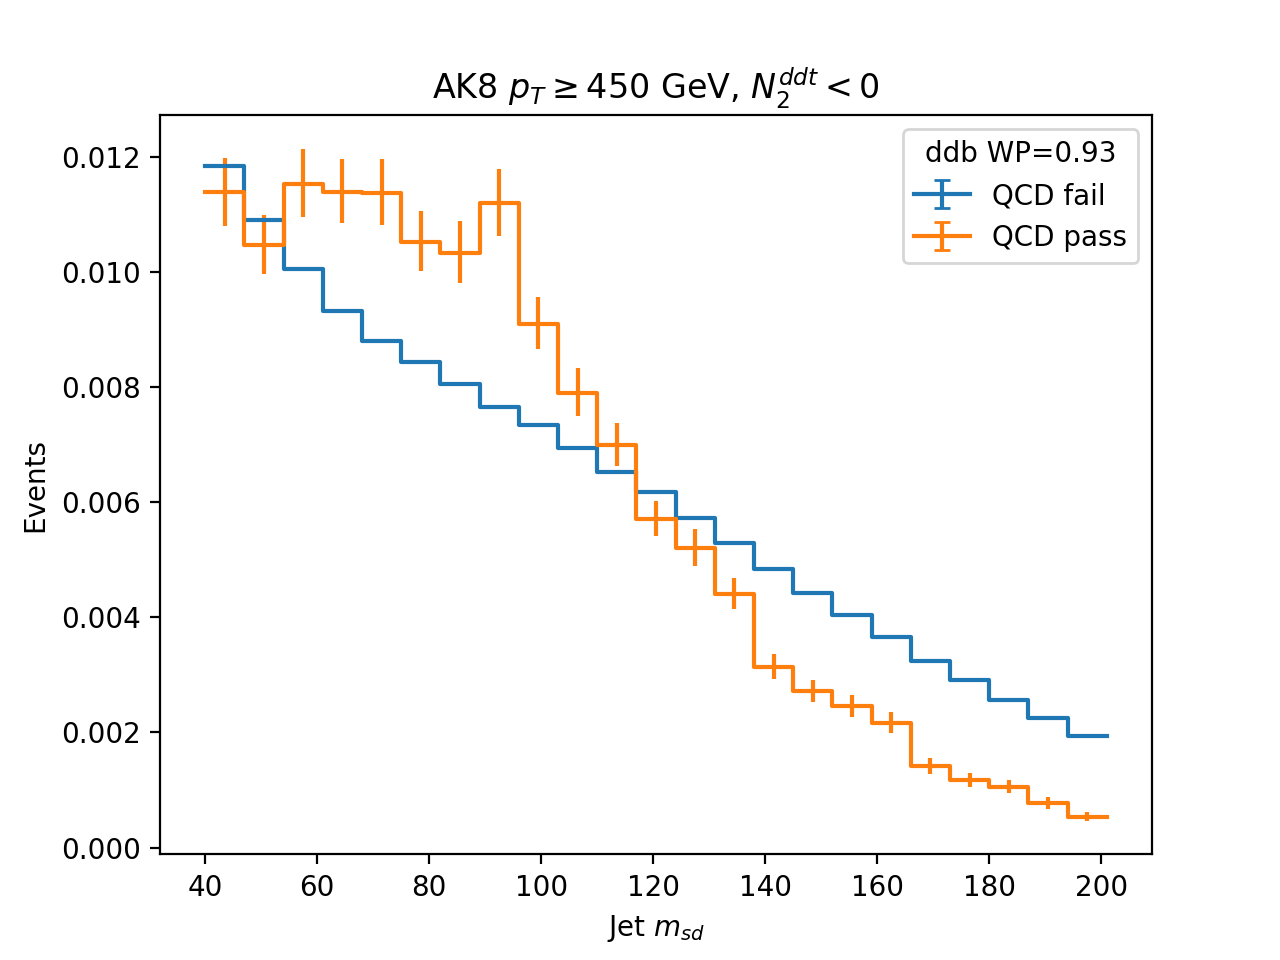

In [23]:
sculpt = hists['hsculpt']
h = sculpt.sum("AK8Puppijet0_deepdoublec","AK8Puppijet0_deepdoublecvb", overflow='all') \
    .project("AK8Puppijet0_pt", slice(450, None), overflow='over') \
    .project("AK8Puppijet0_N2sdb1_ddt", slice(None,0.)) \
    .project("process", "QCD")

for ddb_bin in h.identifiers("AK8Puppijet0_deepdoubleb"):
    fig, ax = plt.subplots(1,1)
    wp = ddb_bin.lo
    hfail = h.project("AK8Puppijet0_deepdoubleb", slice(None, wp), overflow='under')
    hpass = h.project("AK8Puppijet0_deepdoubleb", slice(wp, None), overflow='over')
    plot.plot1d(hfail, ax=ax, clear=False, error_opts={'label': 'QCD fail'}, density=True)
    plot.plot1d(hpass, ax=ax, clear=False, error_opts={'label': 'QCD pass'}, density=True)
    ax.legend(title="ddb WP=%.2f" % wp)
    ax.set_title("AK8 $p_{T}\geq 450$ GeV, $N_{2}^{ddt}<0$")
    fig.savefig("scuplt_ddb_wp%s.pdf" % str(wp).replace('.','p'))

In [24]:
h.identifiers("AK8Puppijet0_deepdoubleb")

[<Interval ([0.7, 0.85)) instance at 0x1232c81d0>,
 <Interval ([0.85, 0.89)) instance at 0x1232c8208>,
 <Interval ([0.89, 0.92)) instance at 0x1232c8240>,
 <Interval ([0.92, 0.93)) instance at 0x1232c8278>,
 <Interval ([0.93, 0.985)) instance at 0x1232c82b0>]

In [25]:
hpass.values(overflow='all')[()][3]

73.73955

In [26]:
x[3:].sum()

<Hist (process,AK8Puppijet0_deepdoubleb,AK8Puppijet0_deepdoublec,AK8Puppijet0_deepdoublecvb) instance at 0x12db60c50>